# [DRAFT] Dirichlet problem on a circle.

## TODO: 

* Based on mms_circle
* Deal with the homogeneous solution.
* Add back in the body force.
* The remaining fundamental issue is the singularity in the volume integral. Set up a way of testing the accuracy of this integral.

## Setup

## Direct to surface eval

For the Poisson equation with Dirichlet boundary conditions:
\begin{split}
\nabla u &= f  ~~ \textrm{in} ~~ \Omega\\
u &= g ~~ \textrm{on} ~~ \partial \Omega
\end{split}
`u_body_force` is the integral:

\begin{equation}
v(x) = \int_{\Omega} G(x,y) f(y) dy
\end{equation}

which satisfies equation 1 but not 2.

Then, compute homogeneous solution with appropriate boundary conditions:

\begin{split}
\nabla u^H &= 0 ~~ \textrm{in} ~~ \Omega \\
u^H &= g - v|_{\partial \Omega}  ~~ \textrm{on} ~~ \partial \Omega
\end{split}

So, first, I need to compute $g - v|_{\partial \Omega}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import common
import sympy as sp

%config InlineBackend.figure_format='retina'

n_q = 200
circle_rule = list(common.trapezoidal_rule(n_q))

t = sp.symbols("t")
theta = sp.pi * (t + 1)
circle_rule[1] *= np.pi

sym_circle = common.symbolic_surface(t, sp.cos(theta), sp.sin(theta))
circle = common.symbolic_eval(t, circle_rule[0], sym_circle)

In [2]:
np.sum(np.cos((circle_rule[0] + 1) * np.pi) ** 4 * circle_rule[1])

2.356194490192345

In [3]:
## This is g
def soln_fnc(x, y):
    return 2 + x + y

bcs = soln_fnc(circle[0], circle[1])

In [4]:
kappa = 3
qbx_p = 8
mult = 1.0

if kappa != 1:
    refined_circle_rule = list(common.trapezoidal_rule(kappa * circle_rule[0].shape[0]))
    refined_circle_rule[1] *= np.pi
    refined_circle = common.symbolic_eval(t, refined_circle_rule[0], sym_circle)
else:
    refined_circle_rule = circle_rule
    refined_circle = circle

qbx_center_x, qbx_center_y, qbx_r = common.qbx_choose_centers(
    circle, circle_rule, mult=mult, direction=-1.0
)

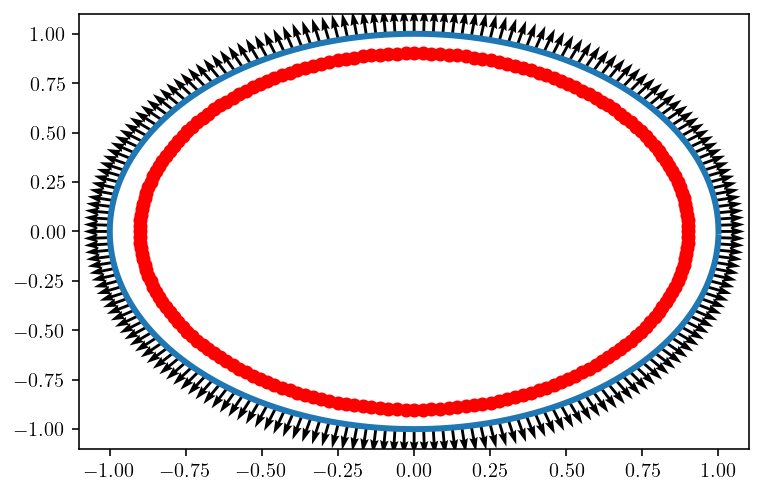

In [5]:
plt.plot(circle[0], circle[1])
plt.quiver(circle[0], circle[1], circle[2], circle[3])
plt.plot(qbx_center_x, qbx_center_y, "ro")

In [6]:
qbx_expand = common.qbx_expand_matrix(
    common.double_layer_matrix,
    refined_circle,
    refined_circle_rule,
    qbx_center_x,
    qbx_center_y,
    qbx_r,
    qbx_p=qbx_p,
)
qbx_eval = common.qbx_eval_matrix(
    circle[0][None, :],
    circle[1][None, :],
    qbx_center_x,
    qbx_center_y,
    qbx_p=qbx_p,
)[0]
A_raw = np.real(np.sum(qbx_eval[:, None, :, None] * qbx_expand, axis=2))
A_raw = A_raw[:, 0, :]

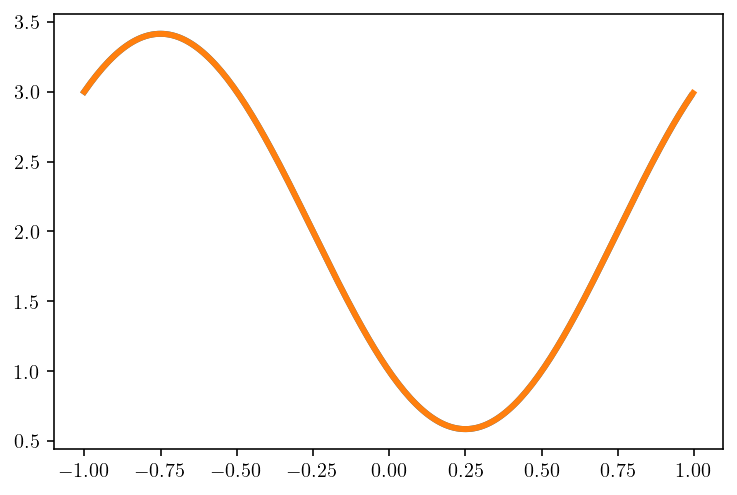

In [7]:
interp_matrix = np.zeros((A_raw.shape[1], A_raw.shape[0]))

for i in range(refined_circle_rule[0].shape[0]):
    offset = i % kappa
    if offset == 0:
        match = i // kappa
        interp_matrix[i, match] = 1.0
    else:
        below = i // kappa
        above = below + 1
        if above == interp_matrix.shape[1]:
            above = 0
        interp_matrix[i, below] = (kappa - offset) / kappa
        interp_matrix[i, above] = offset / kappa

plt.plot(circle_rule[0], bcs)
plt.plot(refined_circle_rule[0], interp_matrix.dot(bcs))

In [8]:
A = A_raw.dot(interp_matrix)
surf_density = np.linalg.solve(A, bcs)

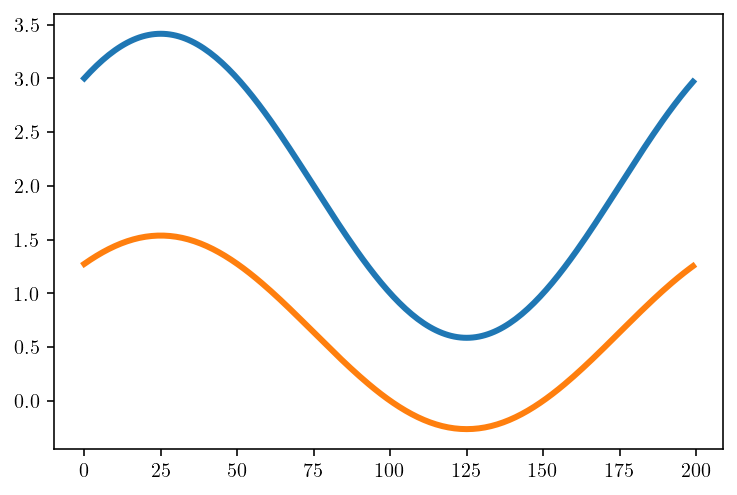

In [9]:
plt.plot(bcs)
plt.plot(surf_density)
plt.show()

In [10]:
nobs = 200
offset = -0.1
zoomx = [-1.0 + offset, 1.0 - offset]
zoomy = [-1.0 + offset, 1.0 - offset]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs2d = np.array([obsx.flatten(), obsy.flatten()]).T.copy()
obs2d_mask = np.sqrt(obs2d[:, 0] ** 2 + obs2d[:, 1] ** 2) <= 1
obs2d_mask_sq = obs2d_mask.reshape(obsx.shape)
obs2d_mask_away = np.sqrt(obs2d[:, 0] ** 2 + obs2d[:, 1] ** 2) <= 0.9
obs2d_mask_away_sq = obs2d_mask_away.reshape(obsx.shape)
correct = soln_fnc(obsx, obsy)

In [11]:
u_rough = (
    common.double_layer_matrix(circle, circle_rule, obsx.flatten(), obsy.flatten())
    .dot(surf_density)
    .reshape(obsx.shape)
)

In [12]:
refined_density = interp_matrix.dot(surf_density)

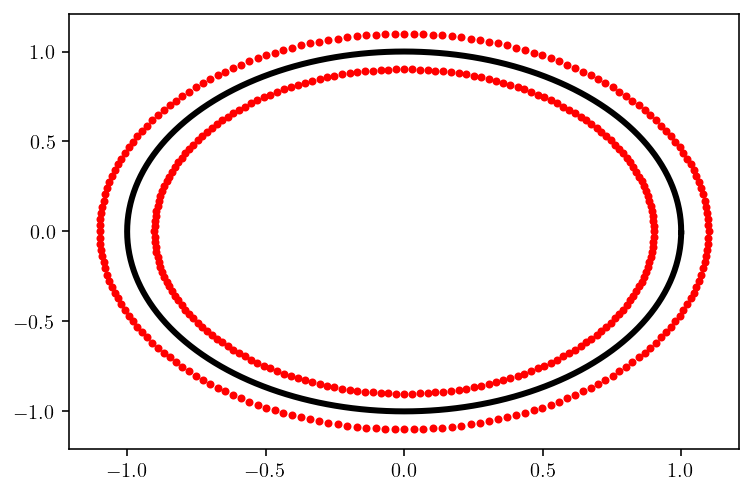

In [13]:
u_smooth = common.interior_eval(
    common.double_layer_matrix,
    circle,
    circle_rule,
    surf_density,
    obsx.flatten(),
    obsy.flatten(),
    kappa=kappa,
    offset_mult=mult,
    qbx_p=qbx_p,
    quad_rule_qbx=refined_circle_rule,
    surface_qbx=refined_circle,
    slip_qbx=refined_density,
    visualize_centers=True,
).reshape(obsx.shape)

In [14]:
u_soln = u_smooth

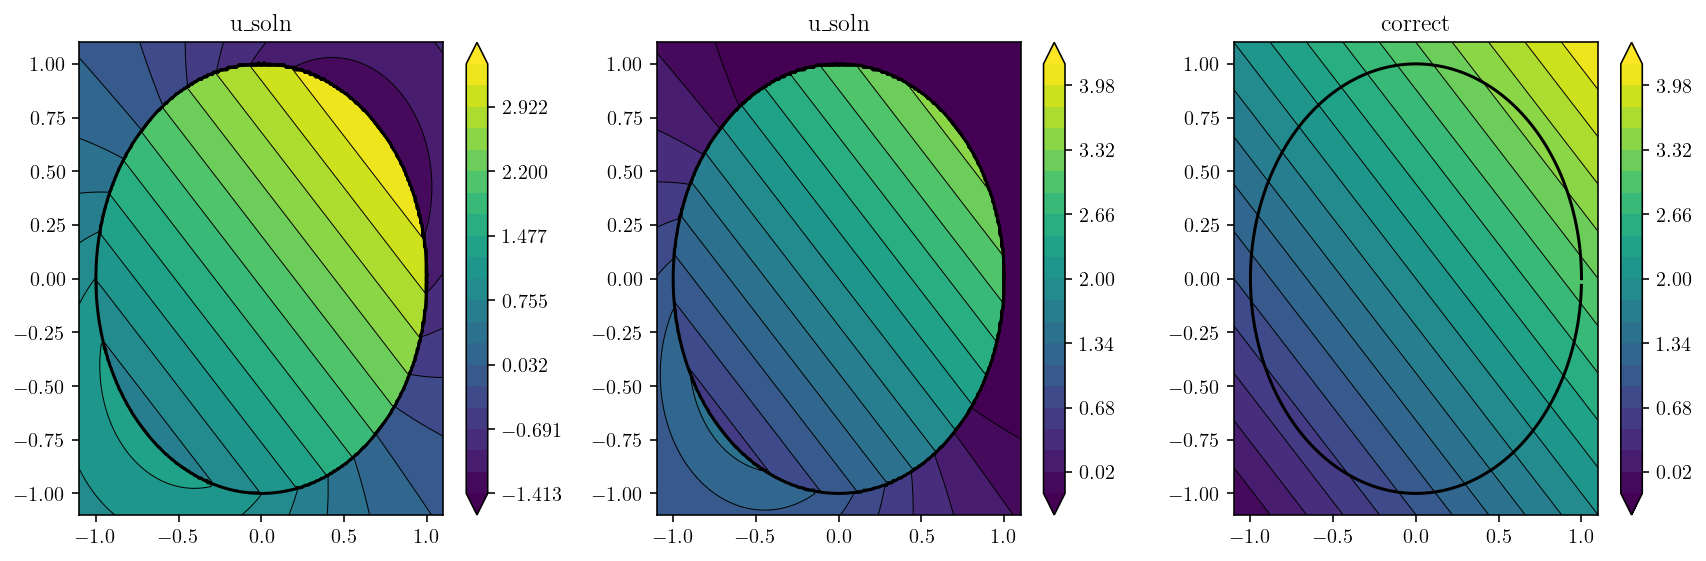

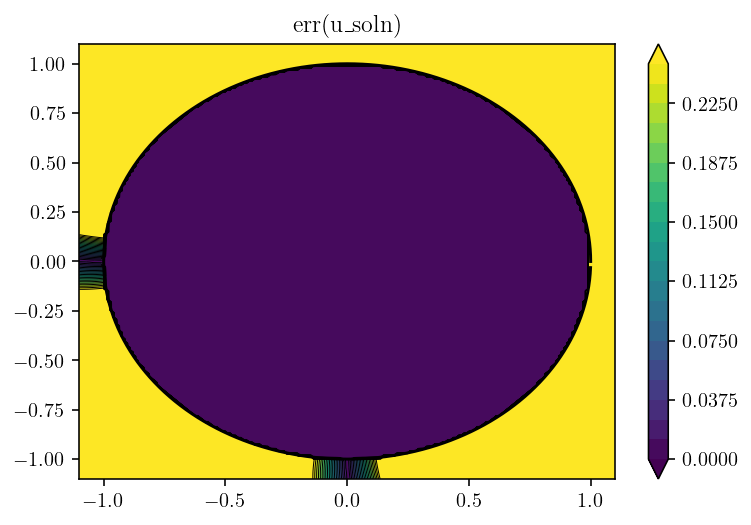

In [15]:
plt.figure(figsize=(12, 4))
for i, to_plot in enumerate([u_soln, u_soln, correct]):
    plt.subplot(1, 3, 1 + i)
    if i == 0:
        levels = np.linspace(np.min(to_plot), np.max(to_plot), 21)
    else:
        cmin = np.min(correct)
        cmax = np.max(correct)
        if cmin == cmax:
            cmin = 0.9 * cmin
            cmax = 1.1 * cmax
        levels = np.linspace(cmin, cmax, 21)

    cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        to_plot,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(circle[0], circle[1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(["u\_soln", "u\_soln", "correct"][i])
plt.tight_layout()

plt.figure()
to_plot = np.abs(correct - u_soln)
levels = np.linspace(0, 0.25, 21)
cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    to_plot,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(circle[0], circle[1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.title("err(u\_soln)")
plt.show()